In [316]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [318]:
session_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
session_df = pd.read_csv(session_file)


In [319]:
session_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

In [320]:
# Filtering

session_df_filt = session_df.loc[:, ['subject_id', 'session_date', 
                                     'session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials']]

session_df_filt.columns.to_list()


['subject_id',
 'session_date',
 'session',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'p_reward_sum_mean',
 'effective_block_length_mean',
 'autowater_collected',
 'autowater_ignored',
 'ignore_rate',
 'reward_rate',
 'finished_rate',
 'double_dipping_rate_finished_trials',
 'double_dipping_rate_finished_reward_trials',
 'double_dipping_rate_finished_noreward_trials',
 'lick_consistency_mean_finished_trials',
 'lick_consistency_mean_finished_reward_trials',
 'lick_consistency_mean_finished_noreward_trials',
 'foraging_performance',
 'foraging_eff',
 'early_lick_rate',
 'invalid_lick_ratio',
 'double_dipping_rate_finished_trials',
 'lick_consistency_mean_finished_trials']

In [321]:
# Feature notes

# finished rate -- upwards increase at stage level, plateu at session 20

# ignore rate -- downwards decrease at stage level, plateu at session 20

# reward rate -- V shape (STAGE_3) at stage level, sig. decrease until session 10 then slow decrease

# median reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# mean reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# early lick rate -- upwards V shape (STAGE_3) at stage level, plateu at session 20

# invalid lick ratio -- slight increase at stage level (but only until STAGE_FINAL), ONLY until session ~7

# double dipping rate (finished trials) -- large decrease at until STAGE_2, then flat,  plateu at session 20

# double dipping rate rewarded (finished trials) -- decrease at stage level,  plateu at session 10

# double dipping rate non-rewarded (finished trials) -- decrease at stage level but only until STAGE_2,  plateu at session 10

# lick consistency mean (finished trials) -- increase at stage level, plateu at session 20

# lick consistency mean (finished reward trials) -- increase at stage level, plateu at session 10

# lick consistency mean (finished non-rewarded trials) -- increase until STAGE 3, then slight decrease, plateu at session 10



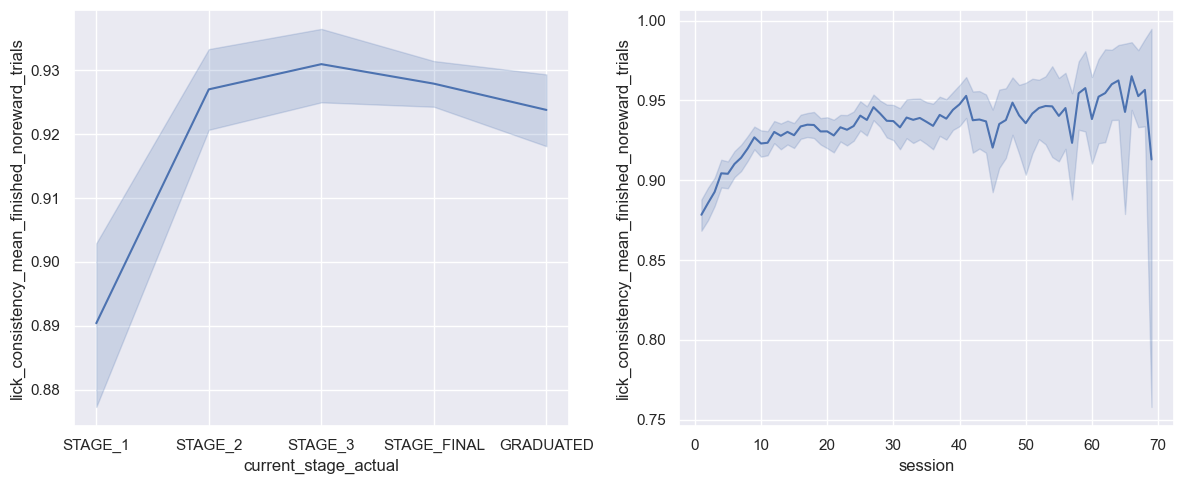

In [399]:

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
session_df['current_stage_actual'] = pd.Categorical(session_df['current_stage_actual'], categories=stage_order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

metric = 'lick_consistency_mean_finished_noreward_trials'

# Plot by stage
sns.lineplot(data=session_df, x='current_stage_actual', y=metric, ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=session_df, x='session', y= metric, 
              ax=ax2)


plt.tight_layout()

In [533]:
# Protyping metrics

test_session_df = session_df.copy()

# Testing filtering
version = '2.3'
version_filt_test_session_df = test_session_df[test_session_df['curriculum_version'] == version]
curriculum_name = 'Uncoupled Baiting'
curriculum_filt_test_session_df = test_session_df[test_session_df['curriculum_name'] == curriculum_name]


# Prototype metric 1: 1 / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_1'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_2'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['finished_rate']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
curriculum_filt_test_session_df['prototype_metric_3'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    ((curriculum_filt_test_session_df['finished_rate'] / curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + (curriculum_filt_test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
curriculum_filt_test_session_df['prototype_metric_4'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
curriculum_filt_test_session_df['prototype_metric_5'] = (
    (2 * curriculum_filt_test_session_df['finished_rate'] * curriculum_filt_test_session_df['reward_rate'] * 
     curriculum_filt_test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + curriculum_filt_test_session_df['early_lick_rate'] + 
     2 * curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] +
     curriculum_filt_test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
#test_session_df = bu.filter_by_group_size(test_session_df, group_col='subject_id', max_rows=30)
curriculum_filt_test_session_df = bu.clean_dataframe(curriculum_filt_test_session_df, threshold=0.5, verbose=True)
curriculum_filt_test_session_df = bu.add_session_column(curriculum_filt_test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
curriculum_filt_test_session_df['current_stage_actual'] = pd.Categorical(curriculum_filt_test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
experiment_description              1406
laser_1_calibration_power           1406
laser_2_calibration_power           1406
laser_1_target_areas                1406
laser_2_target_areas                1406
old_bpod_session                    1406
notes                               1122
results_location                     500
results                              500
injections                           274
subject_genotype                     274
creation_time                        274
session_name                         274
location                             274
fiber_probes                         274
co_data_asset_ID                     274
task_type                            274
session_time                         274
NM_recorded                          274
virus                                274
lickspout_median_pos_y               150
lickspout_movement_range_y           150
lickspout_movemen

In [534]:
bu.analyze_column_distribution(curriculum_filt_test_session_df, 'curriculum_name')

{'value_counts': curriculum_name
 Uncoupled Baiting    1406
 Name: count, dtype: int64,
 'percentages': curriculum_name
 Uncoupled Baiting    100.0
 Name: proportion, dtype: float64,
 'total_count': 1406,
 'unique_values': 1,
 'most_common': ('Uncoupled Baiting', 1406),
 'least_common': ('Uncoupled Baiting', 1406)}

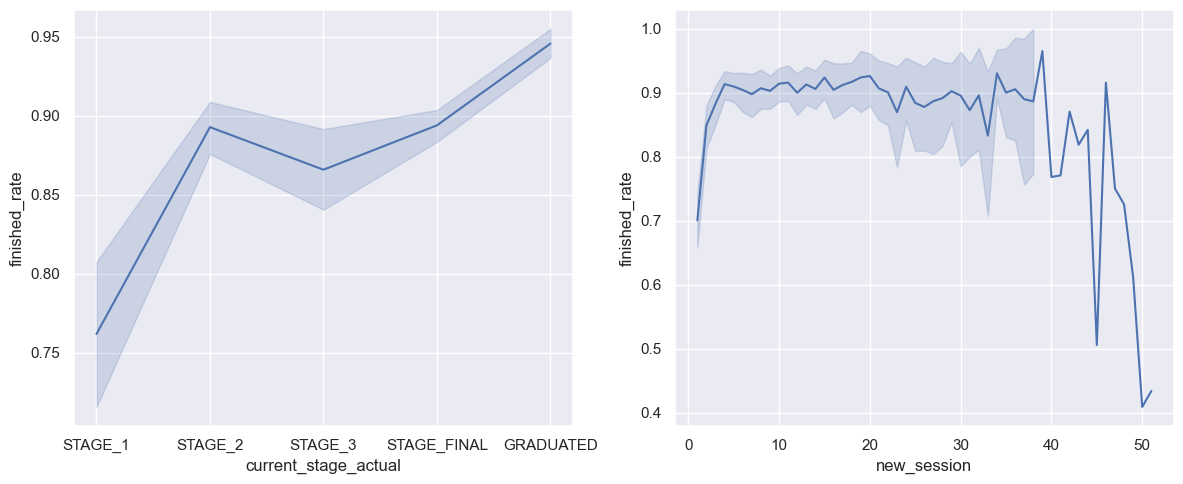

In [536]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='finished_rate', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='finished_rate', 
             ax=ax2)


plt.tight_layout()

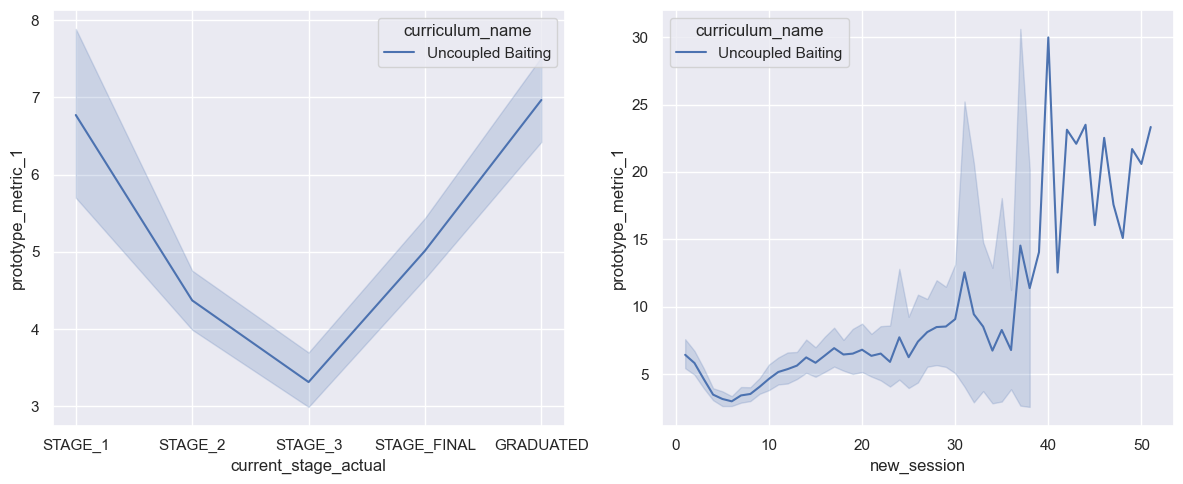

In [538]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_1', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_1', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

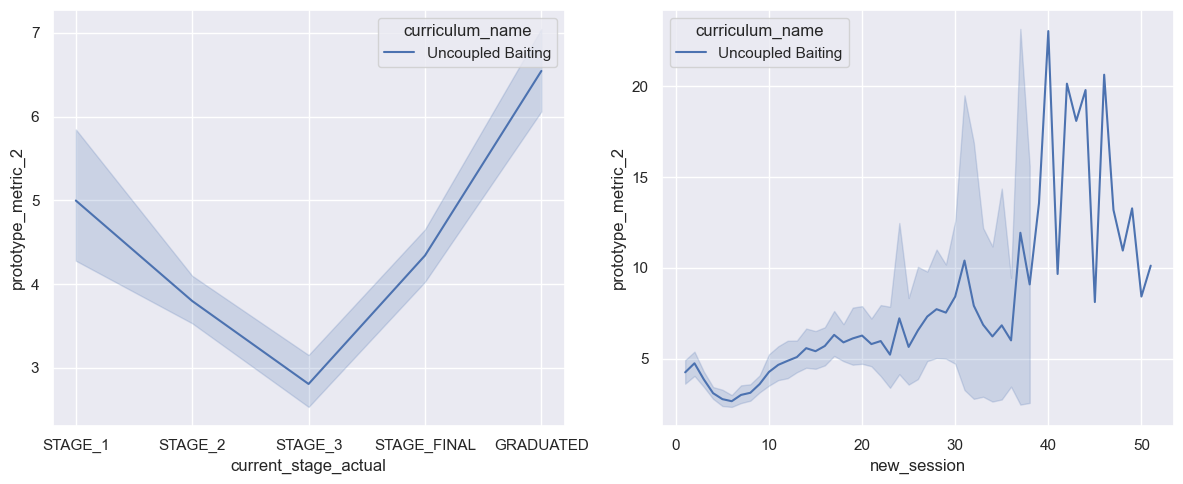

In [537]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_2', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_2', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

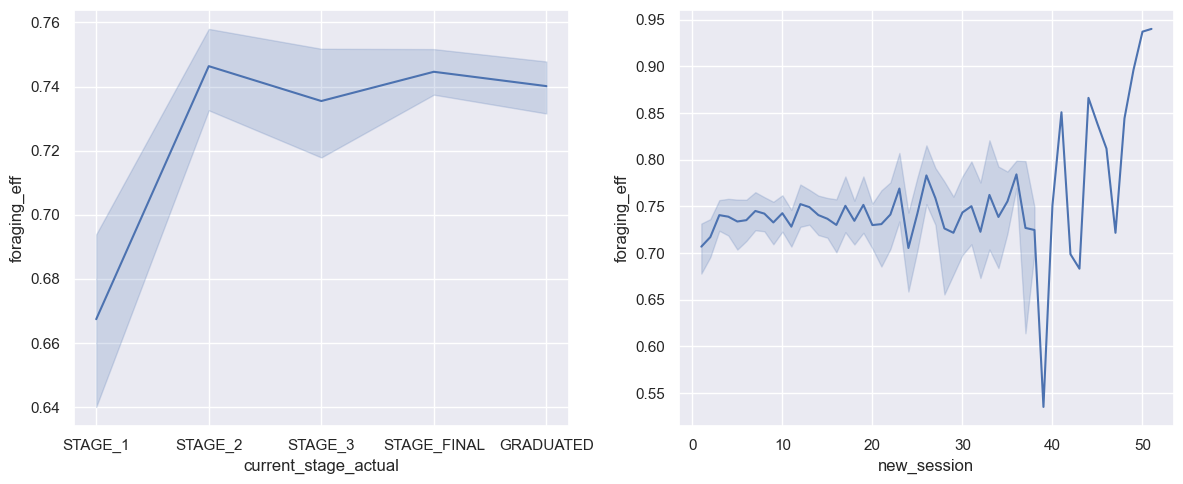

In [539]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='foraging_eff', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='foraging_eff', 
              ax=ax2)


plt.tight_layout()

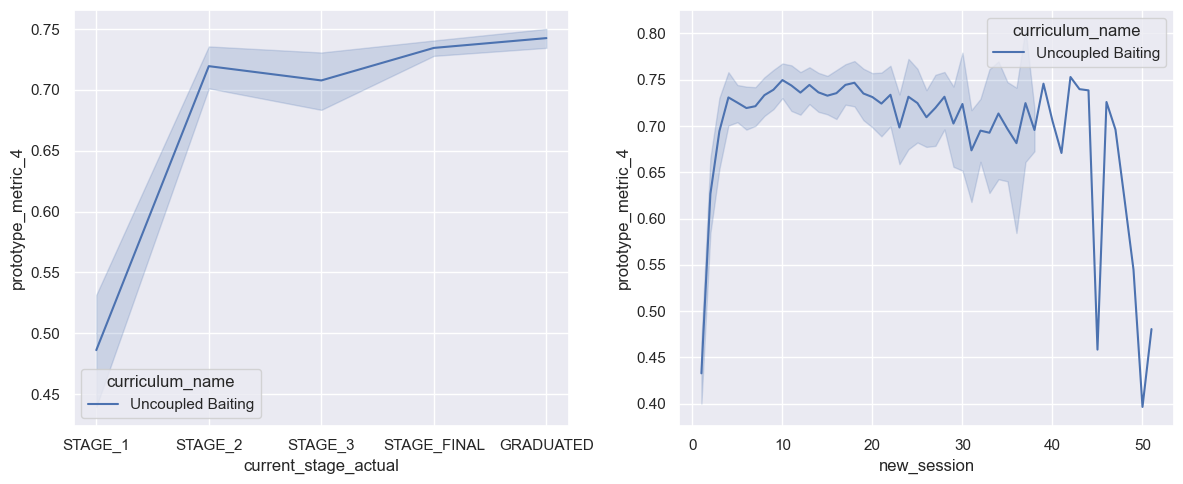

In [540]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_4', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_4', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

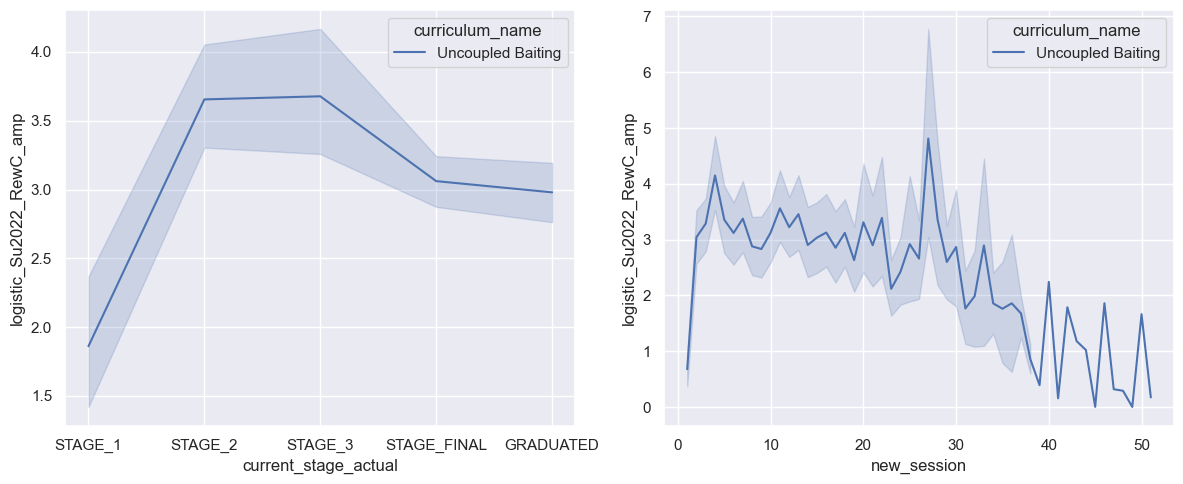

In [541]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='logistic_Su2022_RewC_amp', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='logistic_Su2022_RewC_amp', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

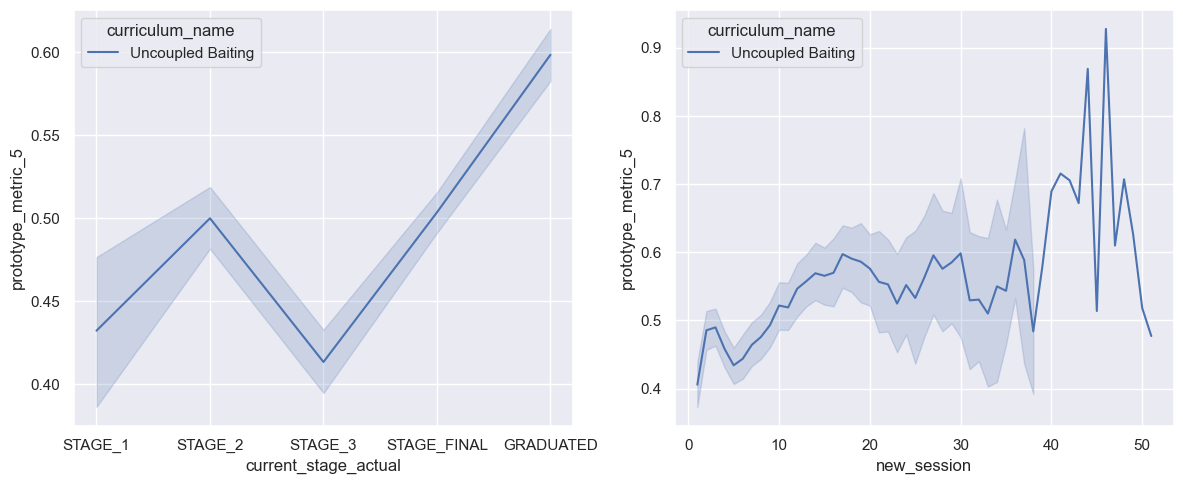

In [542]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [548]:
# Array utils
array_df = curriculum_filt_test_session_df.copy()

# Create custom group limits
stage_counts = array_df.groupby(['subject_id', 'current_stage_actual']).size().unstack(fill_value=0)
stage_lims = {stage: int(stage_counts[stage].quantile(0.95)) for stage in stage_counts.columns}

array_df = bu.filter_by_group_size(array_df, 
                                   group_col='subject_id', 
                                   category_col='current_stage_actual', 
                                   category_limits=stage_lims)


# Generate prototype metric arrays

# Prototype metric 5
prot_type_five = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_5', 
                          task_col=None)

# Prototype metric 4
prot_type_four = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_4', 
                          task_col=None)

# Generate foraging eff array for comparison
foraging_eff_array = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='foraging_eff', 
                          task_col=None)

# Univariate arrays
uni_arrays = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric= 'finished_rate', 
                          task_col=None)



# Summary statistics
au.summary_statistics(prot_type_four)

No data found for nan
No data found for nan
No data found for nan
No data found for nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_1,N/A,"(63, 3)",0.539683,0.686038,0,3,0
1,STAGE_2,N/A,"(63, 3)",1.761905,0.706305,0,3,0
2,STAGE_3,N/A,"(63, 3)",1.015873,0.678281,0,3,0
3,STAGE_FINAL,N/A,"(63, 16)",6.619048,3.953815,0,16,0
4,GRADUATED,N/A,"(63, 13)",2.984127,3.889310,0,13,0


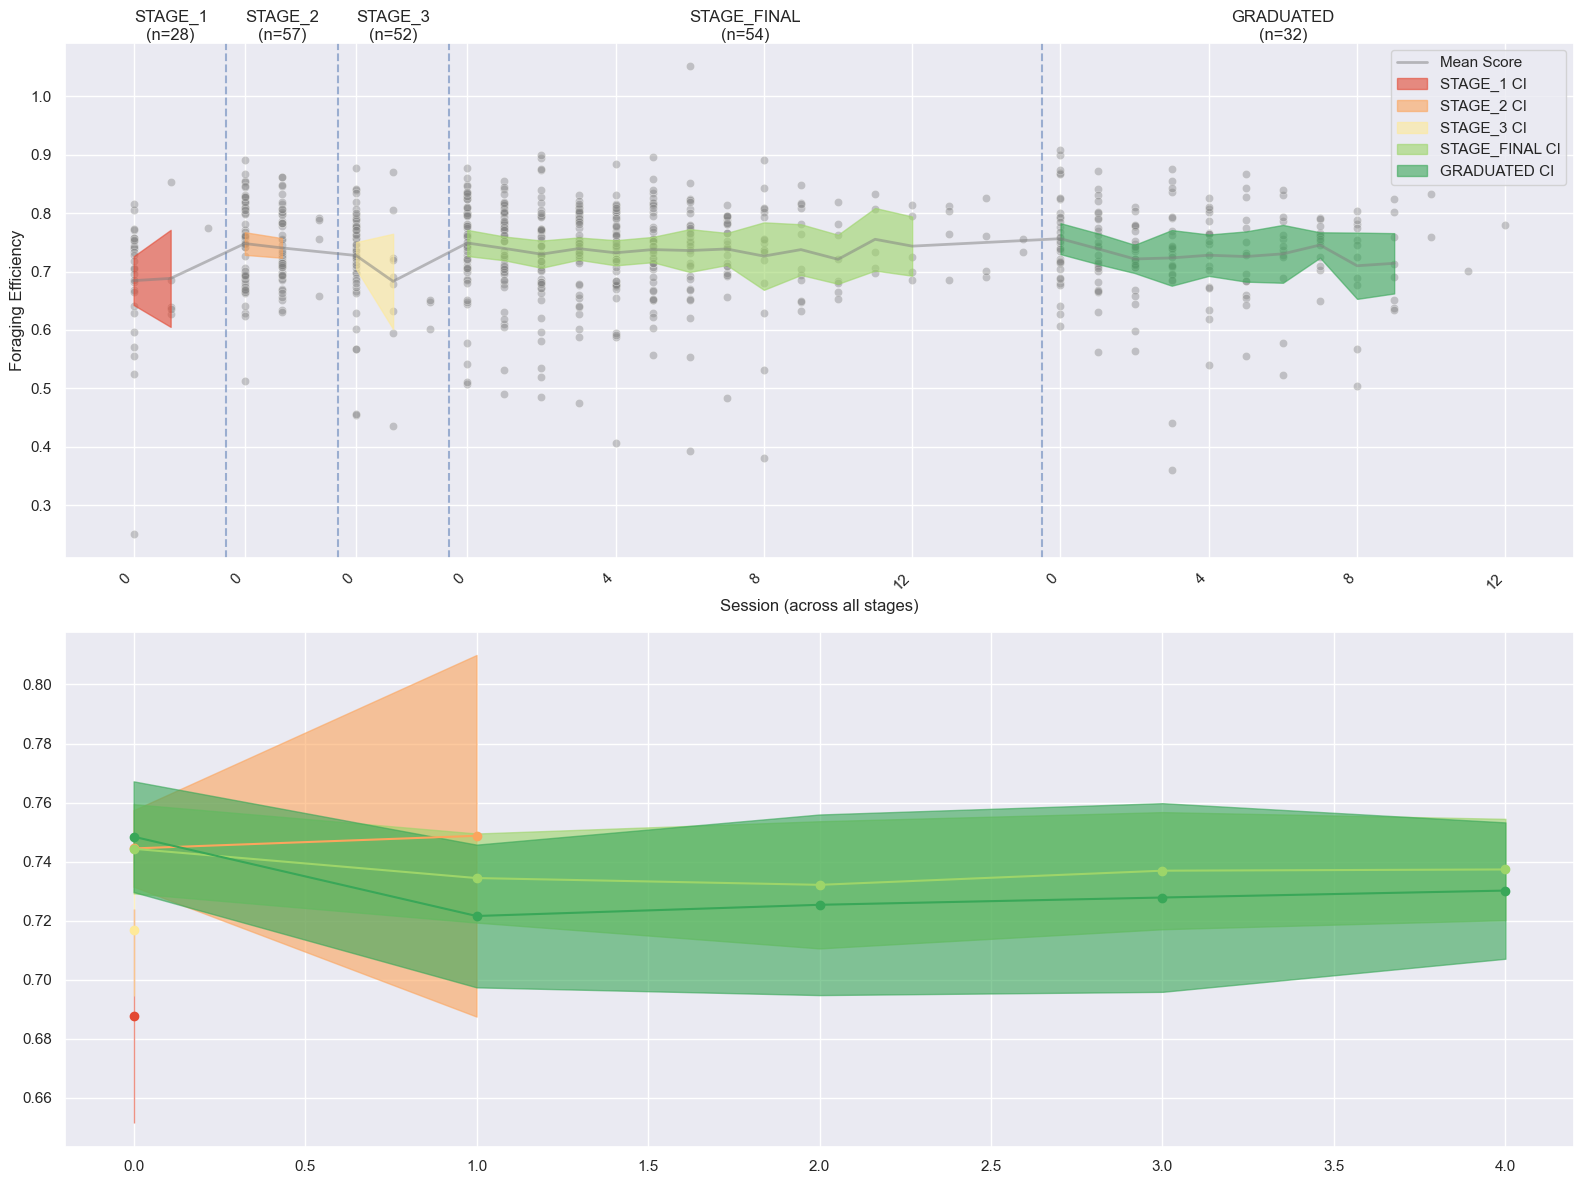


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.733  0.080  0.006  0.361  0.909        32
STAGE_1       34  0.688  0.108  0.019  0.250  0.853        28
STAGE_2      111  0.745  0.068  0.006  0.512  0.892        57
STAGE_3       64  0.717  0.091  0.011  0.436  0.877        52
STAGE_FINAL  417  0.738  0.080  0.004  0.380  1.052        54

Outlier Analysis:

STAGE_1:
Number of outliers: 1
Outlier values: [0.25]
Percentage: 2.9%

STAGE_2:
Number of outliers: 1
Outlier values: [0.51220963]
Percentage: 0.9%

STAGE_3:
Number of outliers: 1
Outlier values: [0.4355183]
Percentage: 1.6%

STAGE_FINAL:
Number of outliers: 8
Outlier values: [0.49091372 0.48594306 0.47522013 0.40638287 1.05190224 0.3928735
 0.48324504 0.38007795]
Percentage: 1.9%

GRADUATED:
Number of outliers: 2
Outlier values: [0.36083722 0.44089602]
Percentage: 1.1%

Performance Summary:

STAGE_1:
Session

In [549]:
au.ci_plot_metric(foraging_eff_array, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True)

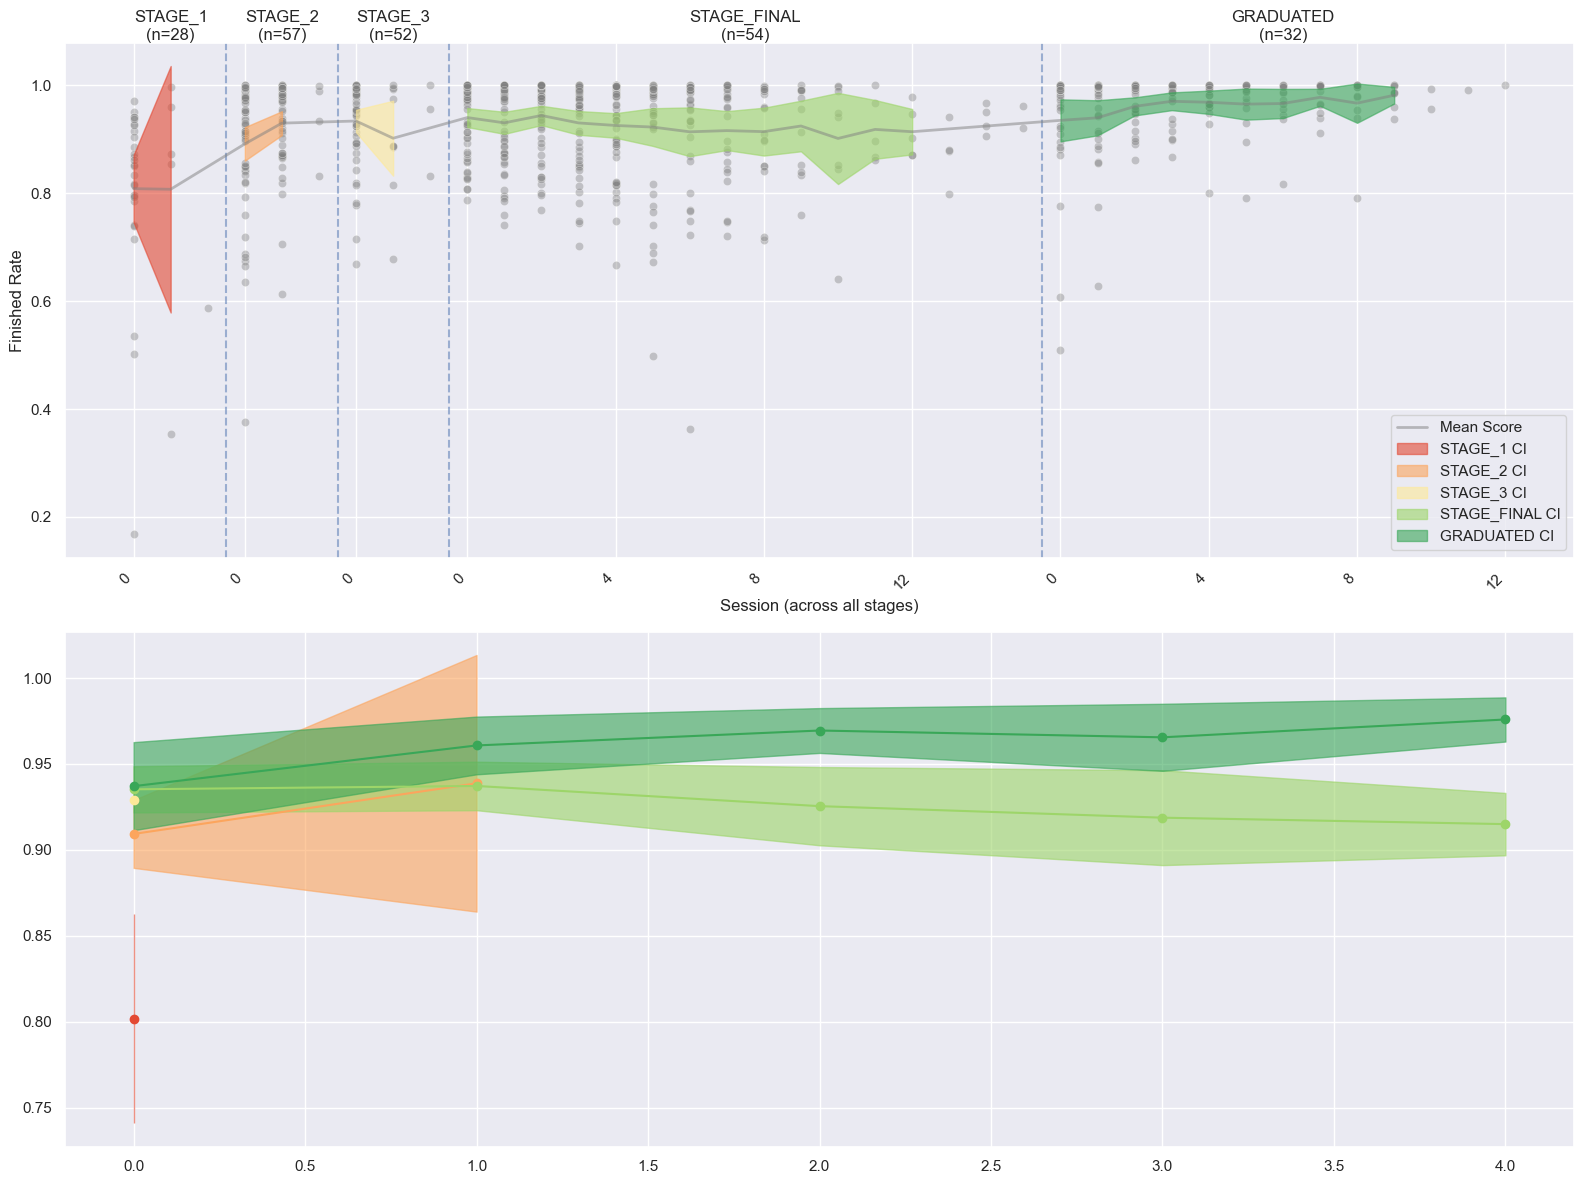


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.959  0.068  0.005  0.509  1.000        32
STAGE_1       34  0.802  0.181  0.031  0.168  0.996        28
STAGE_2      111  0.910  0.103  0.010  0.376  1.000        57
STAGE_3       64  0.929  0.081  0.010  0.668  1.000        52
STAGE_FINAL  417  0.928  0.087  0.004  0.363  1.000        54

Outlier Analysis:

STAGE_1:
Number of outliers: 1
Outlier values: [0.16759777]
Percentage: 2.9%

STAGE_2:
Number of outliers: 1
Outlier values: [0.3757764]
Percentage: 0.9%

STAGE_3:
Number of outliers: 2
Outlier values: [0.66794626 0.67741935]
Percentage: 3.1%

STAGE_FINAL:
Number of outliers: 4
Outlier values: [0.66666667 0.49880096 0.36326531 0.64009112]
Percentage: 1.0%

GRADUATED:
Number of outliers: 3
Outlier values: [0.50900901 0.60833333 0.62772277]
Percentage: 1.6%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM:

In [550]:
au.ci_plot_metric(uni_arrays, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Finished Rate')

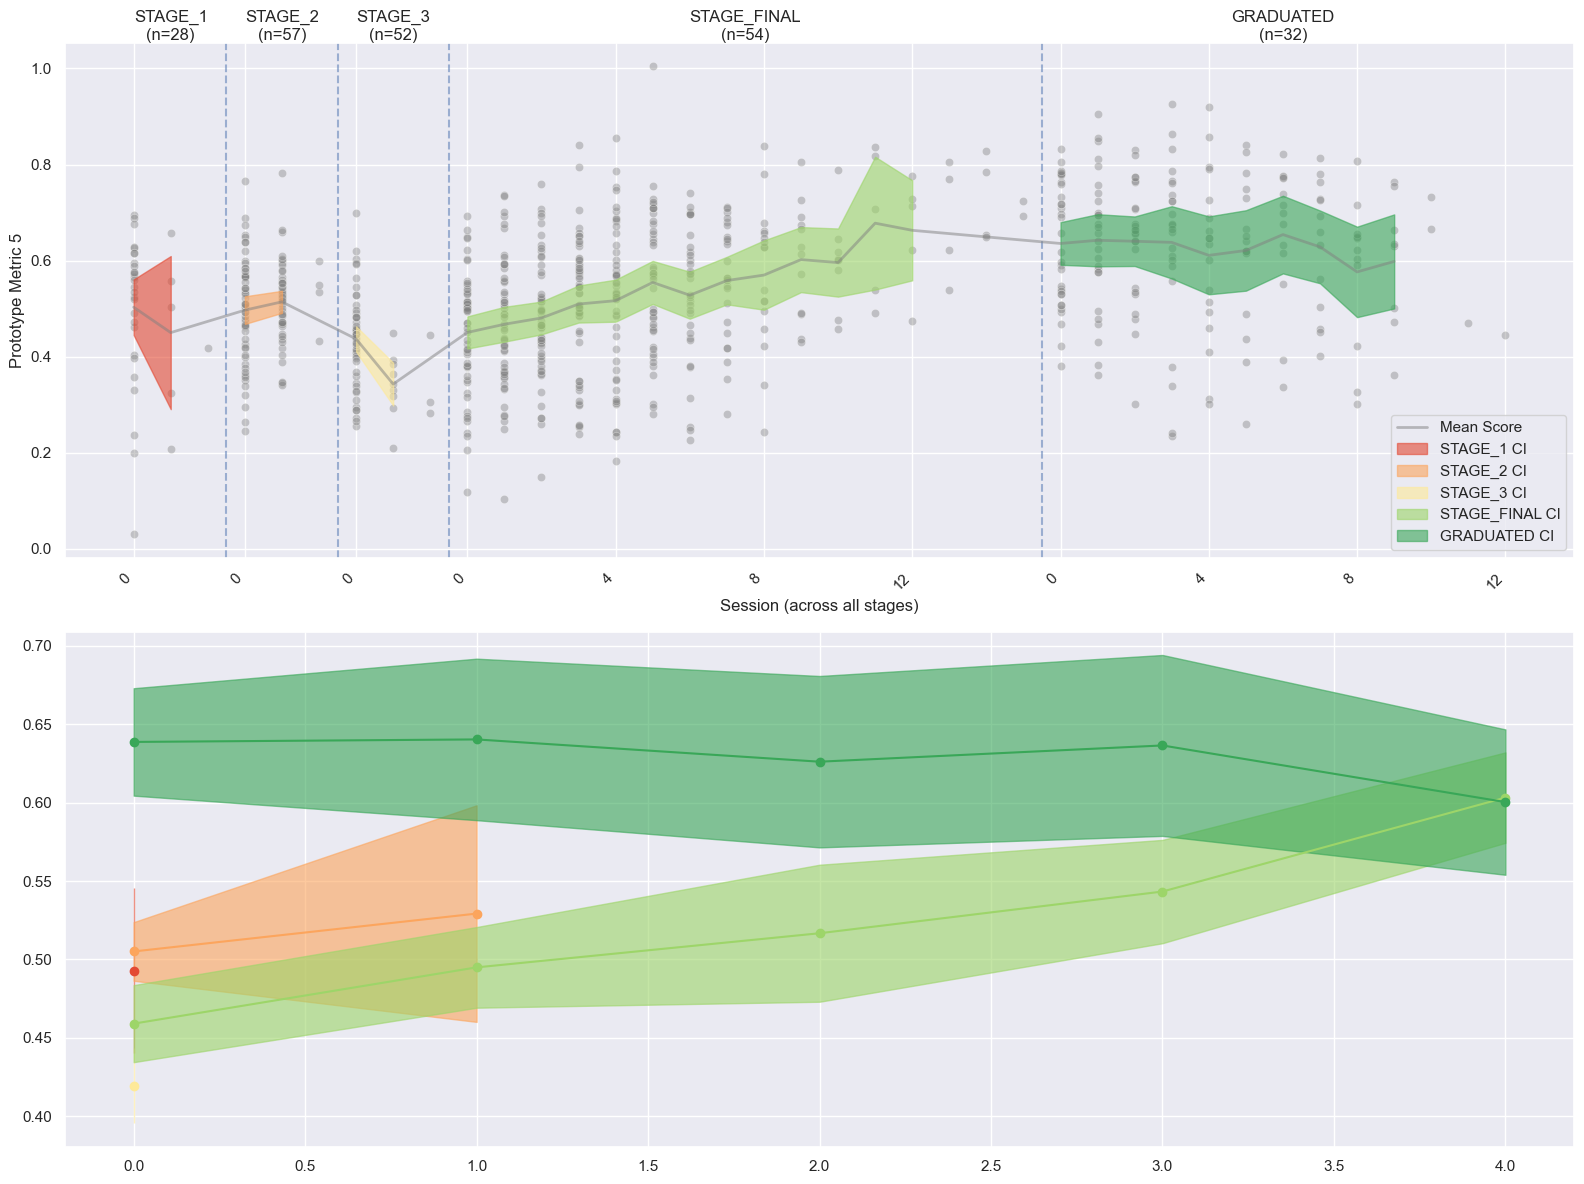


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.629  0.148  0.011  0.235  0.926        32
STAGE_1       34  0.493  0.157  0.027  0.030  0.695        28
STAGE_2      111  0.506  0.098  0.009  0.246  0.782        57
STAGE_3       64  0.419  0.099  0.012  0.210  0.700        52
STAGE_FINAL  417  0.518  0.146  0.007  0.104  1.005        54

Outlier Analysis:

STAGE_FINAL:
Number of outliers: 1
Outlier values: [1.00496414]
Percentage: 0.2%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.477 ± 0.022
Subjects: 28
Sample size range: 1-28
Sessions below threshold: 1

STAGE_2:
Sessions: 3
Mean ± SEM: 0.506 ± 0.007
Subjects: 57
Sample size range: 4-57
Sessions below threshold: 1

STAGE_3:
Sessions: 3
Mean ± SEM: 0.390 ± 0.038
Subjects: 52
Sample size range: 3-52
Sessions below threshold: 1

STAGE_FINAL:
Sessions: 16
Mean ± SEM: 0.552 ± 0.018
Subjects: 54
Sample 

In [551]:
au.ci_plot_metric(prot_type_five, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 5')

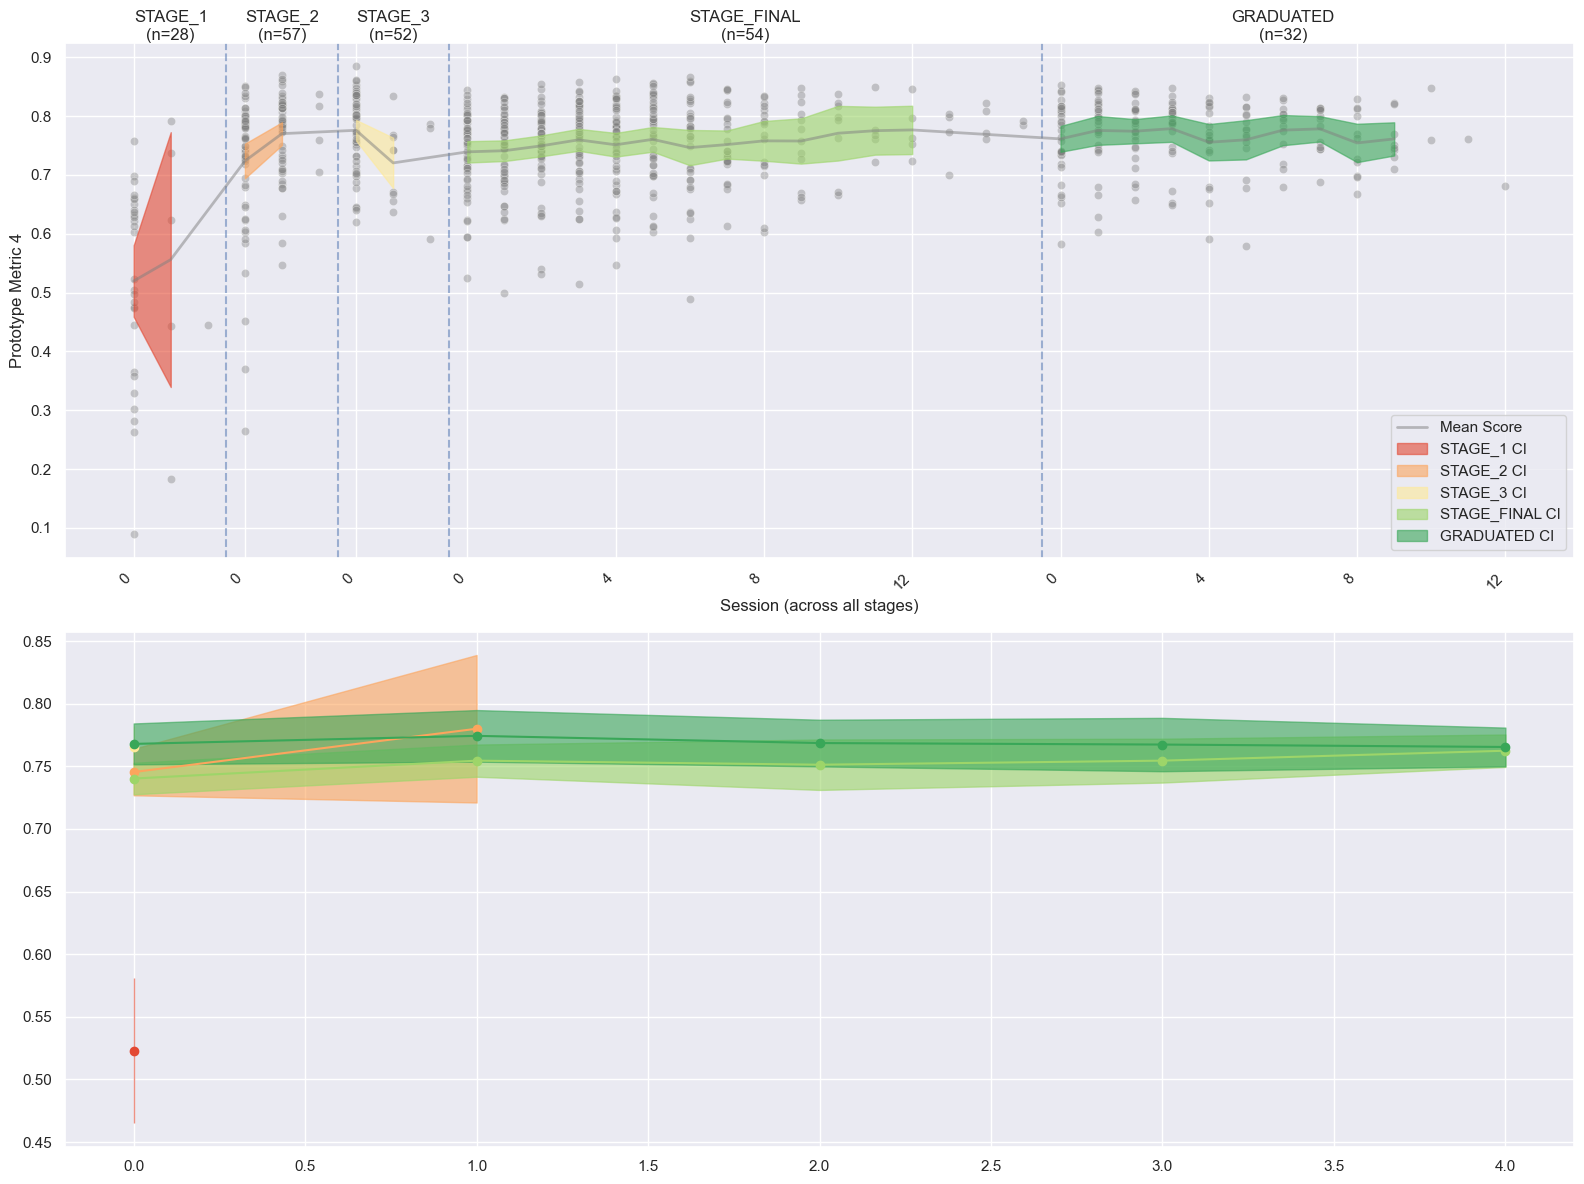


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.768  0.057  0.004  0.580  0.852        32
STAGE_1       34  0.523  0.172  0.030  0.089  0.792        28
STAGE_2      111  0.747  0.097  0.009  0.265  0.870        57
STAGE_3       64  0.765  0.069  0.009  0.592  0.885        52
STAGE_FINAL  417  0.752  0.068  0.003  0.490  0.866        54

Outlier Analysis:

STAGE_2:
Number of outliers: 3
Outlier values: [0.45218769 0.37061277 0.26508537]
Percentage: 2.7%

STAGE_FINAL:
Number of outliers: 6
Outlier values: [0.52501939 0.49856653 0.54053263 0.53117533 0.5144288  0.4898607 ]
Percentage: 1.4%

GRADUATED:
Number of outliers: 3
Outlier values: [0.58303243 0.59131232 0.57964834]
Percentage: 1.6%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.538 ± 0.015
Subjects: 28
Sample size range: 1-28
Sessions below threshold: 1

STAGE_2:
Sessions: 3
Mean ± SEM: 0.747 ± 

In [552]:
au.ci_plot_metric(prot_type_four, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 4')